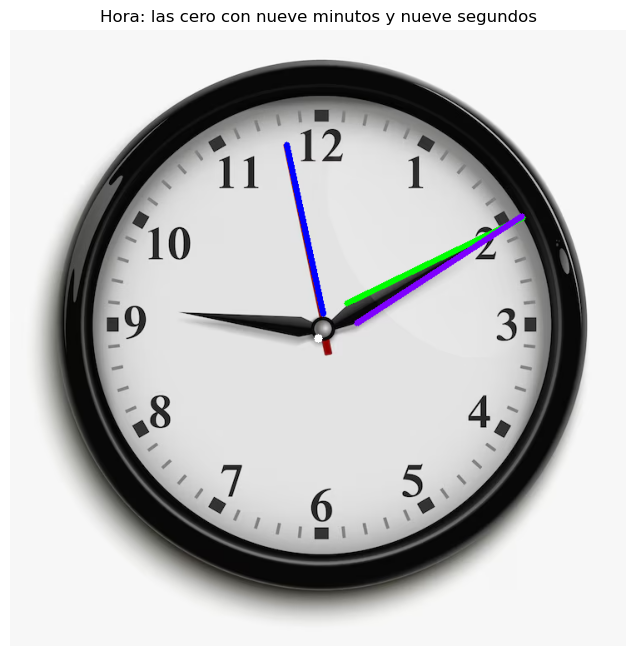

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Cargar imagen manualmente
imagen_bgr = cv2.imread('reloj4.jpg')  # Cambia el nombre manualmente si deseas otra
imagen_rgb = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2RGB)

# Preprocesamiento
gris = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2GRAY)
gris = cv2.GaussianBlur(gris, (5, 5), 1)
gris = cv2.equalizeHist(gris)
bordes = cv2.Canny(gris, 50, 150)

# Detección de líneas
lineas = cv2.HoughLinesP(bordes, 1, np.pi / 180, threshold=80, minLineLength=30, maxLineGap=15)

# Centro de la imagen (asumimos que el reloj está centrado)
centro_x = imagen_bgr.shape[1] // 2
centro_y = imagen_bgr.shape[0] // 2

# Convertir número a texto
def numero_a_texto(n):
    nombres = ['cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez',
        'once', 'doce', 'trece', 'catorce', 'quince', 'dieciséis', 'diecisiete', 'dieciocho', 'diecinueve',
        'veinte', 'veintiuno', 'veintidós', 'veintitrés', 'veinticuatro', 'veinticinco', 'veintiséis',
        'veintisiete', 'veintiocho', 'veintinueve', 'treinta', 'treinta y uno', 'treinta y dos', 'treinta y tres',
        'treinta y cuatro', 'treinta y cinco', 'treinta y seis', 'treinta y siete', 'treinta y ocho',
        'treinta y nueve', 'cuarenta', 'cuarenta y uno', 'cuarenta y dos', 'cuarenta y tres', 'cuarenta y cuatro',
        'cuarenta y cinco', 'cuarenta y seis', 'cuarenta y siete', 'cuarenta y ocho', 'cuarenta y nueve',
        'cincuenta', 'cincuenta y uno', 'cincuenta y dos', 'cincuenta y tres', 'cincuenta y cuatro',
        'cincuenta y cinco', 'cincuenta y seis', 'cincuenta y siete', 'cincuenta y ocho', 'cincuenta y nueve']
    return nombres[n] if 0 <= n < len(nombres) else str(n)

# Calcular ángulo con respecto al centro
def calcular_angulo(x1, y1, x2, y2):
    dist1 = np.hypot(x1 - centro_x, y1 - centro_y)
    dist2 = np.hypot(x2 - centro_x, y2 - centro_y)
    if dist1 < dist2:
        dx = x2 - centro_x
        dy = centro_y - y2
    else:
        dx = x1 - centro_x
        dy = centro_y - y1
    angulo = np.degrees(np.arctan2(dy, dx))
    angulo = (90 - angulo) % 360  # 0° es hacia arriba
    return angulo

# Detectar manecillas
manecillas = []
if lineas is not None:
    for linea in lineas:
        x1, y1, x2, y2 = linea[0]
        longitud = np.hypot(x2 - x1, y2 - y1)
        distancia_centro = min(np.hypot(x1 - centro_x, y1 - centro_y), np.hypot(x2 - centro_x, y2 - centro_y))

        if distancia_centro < 100 and longitud > 30:
            angulo = calcular_angulo(x1, y1, x2, y2)
            manecillas.append({
                'puntos': (x1, y1, x2, y2),
                'longitud': longitud,
                'angulo': angulo
            })

# Detectar hora, minutos y segundos
if len(manecillas) >= 3:
    # Ordenar manecillas por longitud (más corta a más larga)
    manecillas.sort(key=lambda x: x['longitud'])

    # Tomar las tres manecillas más largas (ignorando líneas pequeñas o ruido)
    manecillas_validas = manecillas[-3:]

    # Reordenar esas tres para asegurar que:
    # - hora: más corta
    # - minuto: media
    # - segundo: más larga
    manecillas_validas.sort(key=lambda x: x['longitud'])

    horario = manecillas_validas[0]
    minutero = manecillas_validas[1]
    segundero = manecillas_validas[2]

    

    hora = int((horario['angulo'] / 30) % 12)
    minutos = int((minutero['angulo'] / 6) % 60)
    segundos = int((segundero['angulo'] / 6) % 60)

    # Ajuste por si está entre horas
    fraccion_hora = (horario['angulo'] / 30) % 12
    if abs(fraccion_hora - hora) > 0.5:
        hora = (hora + 1) % 12

    hora_texto = "la una" if hora == 1 else f"las {numero_a_texto(hora)}"
    minutos_texto = numero_a_texto(minutos)
    segundos_texto = numero_a_texto(segundos)

    # Dibujar resultado
    imagen_resultado = imagen_rgb.copy()
    cv2.circle(imagen_resultado, (centro_x, centro_y), 5, (255, 255, 255), -1)
    cv2.line(imagen_resultado, (horario['puntos'][0], horario['puntos'][1]), (horario['puntos'][2], horario['puntos'][3]), (0, 0, 255), 5)  # rojo
    cv2.line(imagen_resultado, (minutero['puntos'][0], minutero['puntos'][1]), (minutero['puntos'][2], minutero['puntos'][3]), (0, 255, 0), 5)  # verde
    cv2.line(imagen_resultado, (segundero['puntos'][0], segundero['puntos'][1]), (segundero['puntos'][2], segundero['puntos'][3]), (127, 0, 255), 5)  # morado

    # Mostrar resultado
    plt.figure(figsize=(8, 8))
    plt.imshow(imagen_resultado)
    plt.title(f'Hora: {hora_texto} con {minutos_texto} minutos y {segundos_texto} segundos')
    plt.axis('off')
    plt.show()
else:
    print("No se detectaron suficientes manecillas.")


d:\Aplicaciones\Anaconda\envs\Practica\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


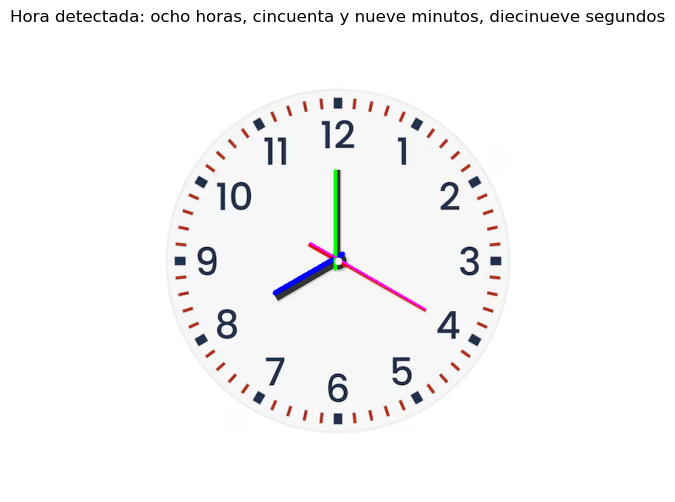

In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def numero_a_texto(n):
    nombres = ['cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez',
        'once', 'doce', 'trece', 'catorce', 'quince', 'dieciséis', 'diecisiete', 'dieciocho', 'diecinueve',
        'veinte', 'veintiuno', 'veintidós', 'veintitrés', 'veinticuatro', 'veinticinco', 'veintiséis',
        'veintisiete', 'veintiocho', 'veintinueve', 'treinta', 'treinta y uno', 'treinta y dos', 'treinta y tres',
        'treinta y cuatro', 'treinta y cinco', 'treinta y seis', 'treinta y siete', 'treinta y ocho',
        'treinta y nueve', 'cuarenta', 'cuarenta y uno', 'cuarenta y dos', 'cuarenta y tres', 'cuarenta y cuatro',
        'cuarenta y cinco', 'cuarenta y seis', 'cuarenta y siete', 'cuarenta y ocho', 'cuarenta y nueve',
        'cincuenta', 'cincuenta y uno', 'cincuenta y dos', 'cincuenta y tres', 'cincuenta y cuatro',
        'cincuenta y cinco', 'cincuenta y seis', 'cincuenta y siete', 'cincuenta y ocho', 'cincuenta y nueve']
    return nombres[n] if 0 <= n < len(nombres) else str(n)

# Cargar imagen
imagen = cv2.imread("reloj2.jpg")  
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Centro de la imagen
centro = (imagen.shape[1] // 2, imagen.shape[0] // 2)

# Preprocesamiento
blur = cv2.GaussianBlur(gris, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)

# Detección de líneas
lineas = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80, minLineLength=40, maxLineGap=10)
candidatas = []

if lineas is not None:
    for l in lineas:
        x1, y1, x2, y2 = l[0]
        d1 = np.hypot(x1 - centro[0], y1 - centro[1])
        d2 = np.hypot(x2 - centro[0], y2 - centro[1])
        if d1 < 120 or d2 < 120:
            if d1 < d2:
                dx = x2 - centro[0]
                dy = centro[1] - y2
            else:
                dx = x1 - centro[0]
                dy = centro[1] - y1
            ang = (np.degrees(np.arctan2(dy, dx)) + 360) % 360
            long = np.hypot(x2 - x1, y2 - y1)
            candidatas.append({'linea': (x1, y1, x2, y2), 'angulo': ang, 'longitud': long})
else:
    print("No se detectaron líneas.")

if len(candidatas) < 3:
    print("No se detectaron suficientes manecillas.")
else:
    data = np.array([[c['angulo']] for c in candidatas])
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=0).fit(data)
    grupos = {0: [], 1: [], 2: []}

    for i, c in enumerate(candidatas):
        grupos[kmeans.labels_[i]].append(c)

    promedios = []
    for g in grupos.values():
        if g:
            angulo_prom = np.mean([x['angulo'] for x in g])
            long_prom = np.mean([x['longitud'] for x in g])
            linea = g[np.argmax([x['longitud'] for x in g])]['linea']
            promedios.append({'angulo': angulo_prom, 'longitud': long_prom, 'linea': linea})

    def angulo_a_tiempo(ang):
        return (90 - ang) % 360

    for p in promedios:
        p['angulo'] = angulo_a_tiempo(p['angulo'])

    promedios.sort(key=lambda x: x['longitud'])
    horario, minutero, segundero = promedios

    hora_real = horario['angulo'] / 30
    hora = int(hora_real)
    minutos = int(minutero['angulo'] // 6)
    segundos = int(segundero['angulo'] // 6)

    resultado = imagen_rgb.copy()
    cv2.line(resultado, (horario['linea'][0], horario['linea'][1]), (horario['linea'][2], horario['linea'][3]), (0, 0, 255), 6)
    cv2.line(resultado, (minutero['linea'][0], minutero['linea'][1]), (minutero['linea'][2], minutero['linea'][3]), (0, 255, 0), 4)
    cv2.line(resultado, (segundero['linea'][0], segundero['linea'][1]), (segundero['linea'][2], segundero['linea'][3]), (255, 0, 255), 2)
    cv2.circle(resultado, centro, 5, (255, 255, 255), -1)

    plt.figure(figsize=(6,6))
    plt.imshow(resultado)
    plt.title(f'Hora detectada: {numero_a_texto(hora)} horas, {numero_a_texto(minutos)} minutos, {numero_a_texto(segundos)} segundos')
    plt.axis('off')
    plt.show()
